In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [2]:
# Dataset loading
file_path = '/content/flights_sample_3m.csv'
df = pd.read_csv(file_path)

print("Dataset's first rows:")
print(df.head())

Dataset's first rows:
      FL_DATE                AIRLINE                AIRLINE_DOT AIRLINE_CODE  \
0  2019-01-09  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
1  2022-11-19   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
2  2022-07-22  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
3  2023-03-06   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
4  2020-02-23       Spirit Air Lines       Spirit Air Lines: NK           NK   

   DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
0     19977       1562    FLL  Fort Lauderdale, FL  EWR   
1     19790       1149    MSP      Minneapolis, MN  SEA   
2     19977        459    DEN           Denver, CO  MSP   
3     19790       2295    MSP      Minneapolis, MN  SFO   
4     20416        407    MCO          Orlando, FL  DFW   

               DEST_CITY  ...  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  \
0             Newark, NJ  ...       0.0             186.0         1

#DATA QUALITY REPORT
The third step focuses on evaluating the quality of the dataset to ensure its suitability for analysis. Poor data quality and integrity are common challenges in projects, and addressing these issues is essential for achieving reliable and meaningful results.

This is the result of verification data quality phase, and it will include several factors that will be analyzed in this notebook.

##Completeness
Completeness in a dataset refers to the extent to which all required data is present to fulfill a specific purpose.

A dataset is considered complete when no essential values are missing or absent.

In [3]:
# Looking for missing values
print("\nNumber of missing values per column:")
null_values = df.isnull().sum()
print(null_values)


Number of missing values per column:
FL_DATE                          0
AIRLINE                          0
AIRLINE_DOT                      0
AIRLINE_CODE                     0
DOT_CODE                         0
FL_NUMBER                        0
ORIGIN                           0
ORIGIN_CITY                      0
DEST                             0
DEST_CITY                        0
CRS_DEP_TIME                     0
DEP_TIME                     77615
DEP_DELAY                    77644
TAXI_OUT                     78806
WHEELS_OFF                   78806
WHEELS_ON                    79944
TAXI_IN                      79944
CRS_ARR_TIME                     0
ARR_TIME                     79942
ARR_DELAY                    86198
CANCELLED                        0
CANCELLATION_CODE          2920860
DIVERTED                         0
CRS_ELAPSED_TIME                14
ELAPSED_TIME                 86198
AIR_TIME                     86198
DISTANCE                         0
DELAY_DUE_CARRIER

As we can see, there are a large number of missing values in various columns of the dataset.

Therefore, completeness is not guaranteed.

##Consistency
Consistency in a dataset denotes the degree of uniformity and coherence among the data.

A dataset is consistent when it does not contain contradictions and adheres to predefined rules or formats (e.g., consistent units of measurement).

In [4]:
# Looking for values different from 0 or 1
# Unique values considered
cancelled_values = df['CANCELLED'].unique()
diverted_values = df['DIVERTED'].unique()

print("Unique values in CANCELLED:", cancelled_values)
print("Unique values in DIVERTED:", diverted_values)

# Check consistency
cancelled_check = set(cancelled_values).issubset({0, 1})
diverted_check = set(diverted_values).issubset({0, 1})

if cancelled_check and diverted_check:
    print("There are no values different from 0 or 1 in CANCELLED and DIVERTED columns.")
else:
    print("There are values different from 0 or 1 in CANCELLED o DIVERTED columns.")

Unique values in CANCELLED: [0. 1.]
Unique values in DIVERTED: [0. 1.]
There are no values different from 0 or 1 in CANCELLED and DIVERTED columns.


In [5]:
# Looking for values different from the yyyy-mm-dd format
# Pattern definition for yyyy-mm-dd format
pattern = r'^\d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01])$'

# Check consistency
fl_date_valid = df['FL_DATE'].apply(lambda x: bool(re.match(pattern, str(x))))

if fl_date_valid.all():
    print("All values in FL_DATE column are coherent with yyyy-mm-dd format.")
else:
    print("There are values in FL_DATE column not coherent with yyyy-mm-dd format.")

    invalid_dates = df.loc[~fl_date_valid, 'FL_DATE']
    print("\nNon valid values:")
    print(invalid_dates)

All values in FL_DATE column are coherent with yyyy-mm-dd format.


In [6]:
# Looking for values different from the hhmm format - int values
dep_time_valid = df['CRS_DEP_TIME'].apply(
    lambda x: isinstance(x, int) and 0 <= x < 2400 and 0 <= x % 100 < 60
)
arr_time_valid = df['CRS_ARR_TIME'].apply(
    lambda x: isinstance(x, int) and 0 <= x < 2400 and 0 <= x % 100 < 60
)

# Check consistency
if dep_time_valid.all() and arr_time_valid.all():
    print("All values in CRS_DEP_TIME and CRS_ARR_TIME columns are coherent with hhmm format.")
else:
    print("There are values in CRS_DEP_TIME and CRS_ARR_TIME columns that aren't coherent with hhmm format.")

    if not dep_time_valid.all():
        print("\nNon valid values in CRS_DEP_TIME:")
        print(df.loc[~dep_time_valid, 'CRS_DEP_TIME'])
    if not arr_time_valid.all():
        print("\nNon valid values in CRS_ARR_TIME:")
        print(df.loc[~arr_time_valid, 'CRS_ARR_TIME'])

There are values in CRS_DEP_TIME and CRS_ARR_TIME columns that aren't coherent with hhmm format.

Non valid values in CRS_ARR_TIME:
27870      2400
139114     2400
212811     2400
242626     2400
350662     2400
675420     2400
723492     2400
898841     2400
930556     2400
1035229    2400
1309662    2400
2054184    2400
2443954    2400
2450973    2400
Name: CRS_ARR_TIME, dtype: int64


In [7]:
# Looking for values different from the hhmm format - float values
dep_time_valid = df['DEP_TIME'].apply(
    lambda x: isinstance(x, float) and not pd.isna(x) and 0 <= int(x) < 2400 and 0 <= int(x) % 100 < 60
)
arr_time_valid = df['ARR_TIME'].apply(
    lambda x: isinstance(x, float) and not pd.isna(x) and 0 <= int(x) < 2400 and 0 <= int(x) % 100 < 60
)

# Check consistency
if dep_time_valid.all() and arr_time_valid.all():
    print("All values in DEP_TIME and ARR_TIME columns are coherent with hhmm format.")
else:
    print("There are values in DEP_TIME and ARR_TIME columns that aren't coherent with hhmm format.")

    if not dep_time_valid.all():
        print("\nNon valid values in DEP_TIME:")
        print(df.loc[~dep_time_valid, 'DEP_TIME'])
    if not arr_time_valid.all():
        print("\nNon valid values in ARR_TIME:")
        print(df.loc[~arr_time_valid, 'ARR_TIME'])

There are values in DEP_TIME and ARR_TIME columns that aren't coherent with hhmm format.

Non valid values in DEP_TIME:
14        NaN
45        NaN
80        NaN
191       NaN
236       NaN
           ..
2999779   NaN
2999865   NaN
2999910   NaN
2999943   NaN
2999946   NaN
Name: DEP_TIME, Length: 77857, dtype: float64

Non valid values in ARR_TIME:
14            NaN
45            NaN
80            NaN
191           NaN
232        2400.0
            ...  
2999779       NaN
2999865       NaN
2999910       NaN
2999943       NaN
2999946       NaN
Name: ARR_TIME, Length: 81358, dtype: float64


As we can see, CANCELLED, DIVERTED, FL_FLIGHT and CRS_DEP_TIME columns are consistent with the format defined.

Whereas, CRS_ARR_TIME is not coherent due to the presence of fourteen values equal to "2400", that should correspond to "0000".

Finally, DEP_TIME and ARR_TIME columns contain a large number of non coherent values, mostly because of Nan values, but also due to the presence of "2400.0" values, that also here should correspond "0000".

# DATA EXPLORATION REPORT
Data exploration is a phase of data analysis aimed at understanding the structure, quality, and patterns within a dataset.

It involves summarizing key statistics, visualizing distributions, and identifying potential anomalies or trends to guide further analysis.

###Categorical features

In this dataset 'AIRLINE', 'AIRLINE_DOT', 'ORIGIN', 'ORIGIN_CITY', 'DEST' and 'DEST_CITY', 'CANCELLED' and 'DIVERTED' are considered the usefull categorical variables.

N.B.

Given the large number of unique values in the majority of the considered categorical variables, visualizing them using histograms or pie charts is not particularly effective. Such visualizations would lack clarity due to the excessive number of categories, making it difficult to interpret meaningful patterns.

Instead, the frequency distribution of values provides a more concise and informative representation of the data, as it allows for a clear understanding of the most frequent and least frequent categories.

Whereas, for binary features like 'CANCELLED' and 'DIVERTED' pie charts will be displayed.

In [8]:
# Categorical variables
categorical_vars = ['AIRLINE', 'AIRLINE_DOT', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CANCELLED', 'DIVERTED']

# Frequency distribution computation
for var in categorical_vars:
    print(f"Frequency distribution for {var}:")
    print(df[var].value_counts())
    print("-" * 50)


Frequency distribution for AIRLINE:
AIRLINE
Southwest Airlines Co.                576470
Delta Air Lines Inc.                  395239
American Airlines Inc.                383106
SkyWest Airlines Inc.                 343737
United Air Lines Inc.                 254504
Republic Airline                      143107
Envoy Air                             121256
JetBlue Airways                       112844
Endeavor Air Inc.                     112463
PSA Airlines Inc.                     107050
Alaska Airlines Inc.                  100467
Spirit Air Lines                       95711
Mesa Airlines Inc.                     65012
Frontier Airlines Inc.                 64466
Allegiant Air                          52738
Hawaiian Airlines Inc.                 32114
Horizon Air                            20634
ExpressJet Airlines LLC d/b/a aha!     19082
Name: count, dtype: int64
--------------------------------------------------
Frequency distribution for AIRLINE_DOT:
AIRLINE_DOT
Southwest Airline

####Identified Anomalies and Observations
- Consistency Between AIRLINE and AIRLINE_DOT

  The frequencies for each airline are identical in both columns. This indicates that AIRLINE_DOT correctly corresponds to AIRLINE by adding the carrier code (e.g., "AS" or "DL").

- Mismatch Between ORIGIN/DEST and ORIGIN_CITY/DEST_CITY:

  The frequency distributions show that there are 380 unique values in both ORIGIN and DEST columns but only 373 unique values in ORIGIN_CITY and DEST_CITY.

  This discrepancy suggests that multiple airport codes map to the same city, which is typical for cities with multiple airports (e.g., New York with JFK, LGA, and EWR).

- Extremely Low-Frequency Values:

  Several airport codes, such as ILG (Wilmington, DE), FLO (Florence, SC), and IPT (Williamsport, PA), have exceptionally low counts, with fewer than 20 occurrences as either origin or destination.

  While this may reflect legitimate data for regional or underutilized airports, it is worth investigating whether these entries are accurate or the result of data entry errors.

- Uneven Distribution:

  Major hubs like Atlanta (ATL), Dallas/Fort Worth (DFW), and Chicago (ORD) dominate the data, as expected for large airports. Conversely, smaller airports have extremely low counts, which might skew the overall distribution.

  This imbalance is typical in aviation datasets but should be considered when analyzing trends or aggregating data.

- Rare Canceled Flights:
  
  The low cancellation rate could reflect robust airline operations.

- Rare Diverted Flights:
  
  Diversions are extremely rare, consistent with real-world aviation patterns where flights are only diverted in exceptional circumstances (e.g., emergencies, weather issues, or airport closures).


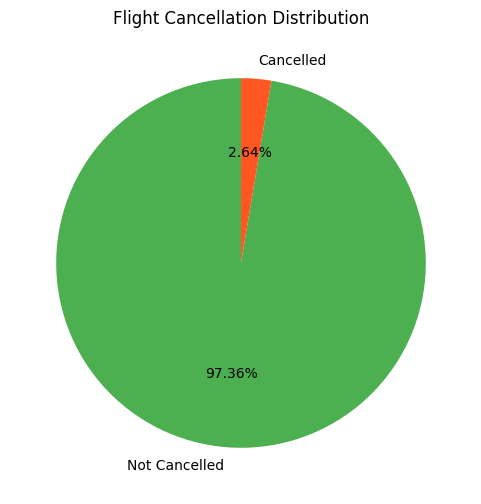

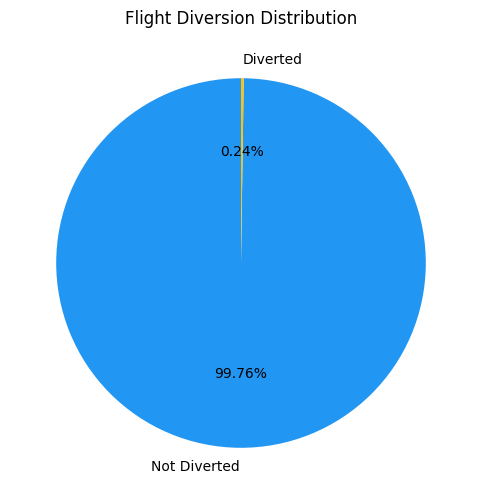

In [9]:
# Pie Chart for CANCELLED
cancelled_counts = df['CANCELLED'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    cancelled_counts,
    labels=['Not Cancelled', 'Cancelled'],
    autopct='%1.2f%%',
    startangle=90,
    colors=['#4CAF50', '#FF5722']
)
plt.title('Flight Cancellation Distribution')
plt.show()

# Pie Chart for DIVERTED
diverted_counts = df['DIVERTED'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    diverted_counts,
    labels=['Not Diverted', 'Diverted'],
    autopct='%1.2f%%',
    startangle=90,
    colors=['#2196F3', '#FFC107']
)
plt.title('Flight Diversion Distribution')
plt.show()

As shown by pie charts, rare canceled flights and diverted flights were revealed.

As a consequence, the low cancellation rate could reflect robust airline operations, and the presence of extremely rare diversions means they are consistent with real-world aviation patterns where flights are only diverted in exceptional circumstances (e.g., emergencies, weather issues, or airport closures).

###Quantitative Variables

In this dataset 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DEP_DELAY', 'ARR_DELAY' and 'DISTANCE' are considered the usefull quantitative variables.

In [10]:
# Quantitative variables considered
quantitative_features = ['CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DEP_DELAY', 'ARR_DELAY', 'DISTANCE']

# Data exploration
for feature in quantitative_features:
    print(f"Data Exploration for: {feature}")
    print("-" * 40)
    print(f"Minimum: {df[feature].min()}")
    print(f"Maximum: {df[feature].max()}")
    print(f"Mean: {df[feature].mean()}")
    print(f"Median: {df[feature].median()}")
    print(f"Mode: {df[feature].mode()[0]}")
    print(f"Standard Deviation: {df[feature].std()}")
    print("-" * 40)
    print("\n")

Data Exploration for: CRS_ELAPSED_TIME
----------------------------------------
Minimum: 1.0
Maximum: 705.0
Mean: 142.27580728710066
Median: 125.0
Mode: 90.0
Standard Deviation: 71.55668973499687
----------------------------------------


Data Exploration for: ELAPSED_TIME
----------------------------------------
Minimum: 15.0
Maximum: 739.0
Mean: 136.6205411349158
Median: 120.0
Mode: 79.0
Standard Deviation: 71.67581550996262
----------------------------------------


Data Exploration for: AIR_TIME
----------------------------------------
Minimum: 8.0
Maximum: 692.0
Mean: 112.31083958347205
Median: 95.0
Mode: 62.0
Standard Deviation: 69.75484349770514
----------------------------------------


Data Exploration for: DEP_DELAY
----------------------------------------
Minimum: -90.0
Maximum: 2966.0
Mean: 10.123326179288219
Median: -2.0
Mode: -5.0
Standard Deviation: 49.251834875076064
----------------------------------------


Data Exploration for: ARR_DELAY
-----------------------------

####Identified Observations
- CRS_ELAPSED_TIME (Scheduled Elapsed Time in minutes)

  - Minimum: 1.0 → Some flights are scheduled for very short durations, likely between nearby airports.
  - Maximum: 705.0 → The longest scheduled flights take over 11 hours, reflecting long-haul travel.
  - Mean (142.28): On average, flights are scheduled to last approximately 2 hours and 22 minutes.
  - Median (125.0): The median scheduled time is lower than the mean, suggesting a concentration of flights with shorter durations.
  - Mode (90.0): The most frequent scheduled duration is 90 minutes, which aligns with short-haul flights.
  - Standard Deviation (71.56): There is significant variability in the scheduled flight durations due to the presence of both short-haul and long-haul flights.


- ELAPSED_TIME (Actual Elapsed Time in minutes)

  - Minimum: 15.0 → Flights with very short actual durations, possibly due to reduced flight paths or faster-than-expected travel.
  - Maximum: 739.0 → The longest flights take over 12 hours, reflecting long-haul travel.
  - Mean (136.62): On average, actual flight durations are approximately 2 hours and 16 minutes.
  - Median (120.0): The median is slightly lower than the mean, indicating that most flights are shorter than the average.
  - Mode (79.0): The most frequent actual duration is 79 minutes, representing common short-haul flights.
  - Standard Deviation (71.68): Similar to CRS_ELAPSED_TIME, there is significant variability in actual flight durations.


- AIR_TIME (Time in the air in minutes)

  - Minimum: 8.0 → Extremely short air times likely between nearby airports.
  - Maximum: 692.0 → Represents very long-haul flights, possibly international.
  - Mean (112.31): On average, flights spend about 1 hour and 52 minutes in the air.
  - Median (95.0): Most flights have air times shorter than the mean, as reflected by the lower median.
  - Mode (62.0): The most frequent air time is 62 minutes, suggesting a prevalence of short-haul flights.
  - Standard Deviation (69.75): A high variation in air time due to the mix of short-haul and long-haul flights.


- DEP_DELAY (Departure Delay in minutes)

  - Minimum: -90.0 → Indicates departures occurring up to 90 minutes earlier than scheduled.
  - Maximum: 2966.0 → Extreme delays, likely caused by disruptions or rescheduling.
  - Mean (10.12): On average, flights are delayed by about 10 minutes.
  - Median (-2.0): A negative median suggests that most flights depart on time or slightly ahead of schedule.
  - Mode (-5.0): The most frequent departure time adjustment is a 5-minute early departure.
  - Standard Deviation (49.25): A wide range of departure times indicates variability, with significant outliers.


- ARR_DELAY (Arrival Delay in minutes)

  - Minimum: -96.0 → Flights arriving up to 96 minutes earlier than scheduled.
  - Maximum: 2934.0 → Extreme arrival delays, likely due to significant disruptions.
  - Mean (4.26): On average, flights arrive 4 minutes late.
  - Median (-7.0): A negative median suggests that most flights arrive on time or early.
  - Mode (-11.0): The most frequent arrival time adjustment is an 11-minute early arrival.
  - Standard Deviation (51.17): A wide range of arrival delays, with significant outliers affecting the distribution.


- DISTANCE (Flight distance in miles)

  - Minimum: 29.0 → Short distances, likely between nearby airports.
  - Maximum: 5812.0 → Very long distances, typical of intercontinental flights.
  - Mean (809.36): The average flight distance is approximately 809 miles, corresponding to medium-haul flights.
  - Median (651.0): The median distance is shorter than the mean, reflecting a concentration of shorter flights.
  - Mode (337.0): The most frequent distance is 337 miles, characteristic of short-haul flights.
  - Standard Deviation (587.89): High variability due to the mix of short, medium, and long-haul flights.


General Observations:

- Scheduled vs Actual Times: Actual flight durations (ELAPSED_TIME) tend to be slightly shorter than scheduled durations (CRS_ELAPSED_TIME), reflecting adjustments in flight operations.
- Delays: Both departure and arrival times show significant variability, with most flights on time or early, but with extreme delays skewing the distribution.
- Distance: The dataset predominantly includes short- and medium-haul flights, with fewer long-haul flights.

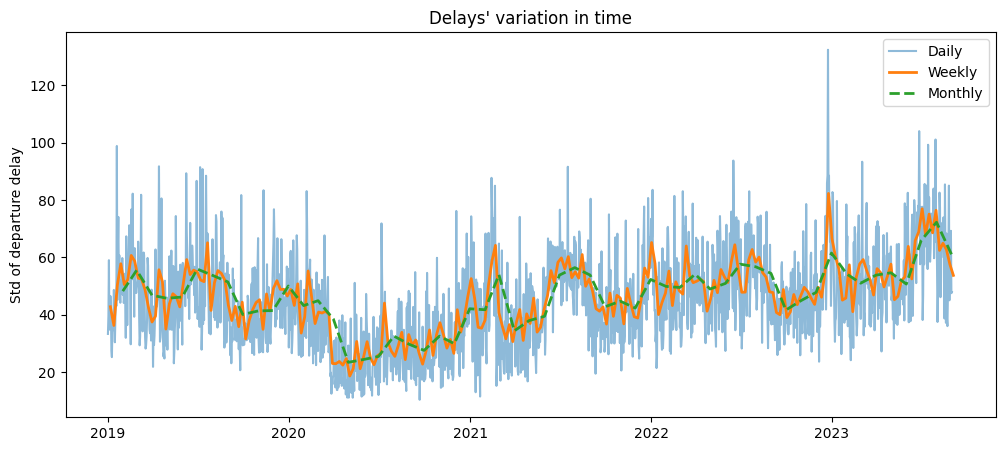

In [11]:
# Looking for patterns to check how quickly flight delays vary
# Analyze the variance and seasonality of delays over different time windows
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Std computed on departure delays for days, weeks and months
df_daily = df.groupby('FL_DATE')['DEP_DELAY'].std()
df_weekly = df.resample('W', on='FL_DATE')['DEP_DELAY'].std()
df_monthly = df.resample('ME', on='FL_DATE')['DEP_DELAY'].std()

# Visualization
plt.figure(figsize=(12,5))
plt.plot(df_daily, label="Daily", alpha=0.5)
plt.plot(df_weekly, label="Weekly", linewidth=2)
plt.plot(df_monthly, label="Monthly", linewidth=2, linestyle="dashed")

plt.title("Delays' variation in time")
plt.ylabel("Std of departure delay")
plt.legend()
plt.show()

The graph illustrates the variation in the standard deviation of flight departure delays over time, computed on daily, weekly, and monthly scales.

- Daily Variation: The blue line representing daily standard deviations shows significant fluctuations, highlighting the inherent noise and randomness of daily flight delays.

- Weekly and Monthly Trends: The orange (weekly) and green (monthly) lines exhibit smoother patterns, as aggregating over longer time periods reduces variability and emphasizes broader trends.

Seasonality and Trends:

- Peaks in delay variability are visible during certain periods, likely corresponding to high-traffic seasons, such as holidays, when delays tend to be more frequent and variable.
- During 2020, a noticeable reduction in variability aligns with the COVID-19 pandemic, reflecting decreased air traffic and fewer operational disruptions.

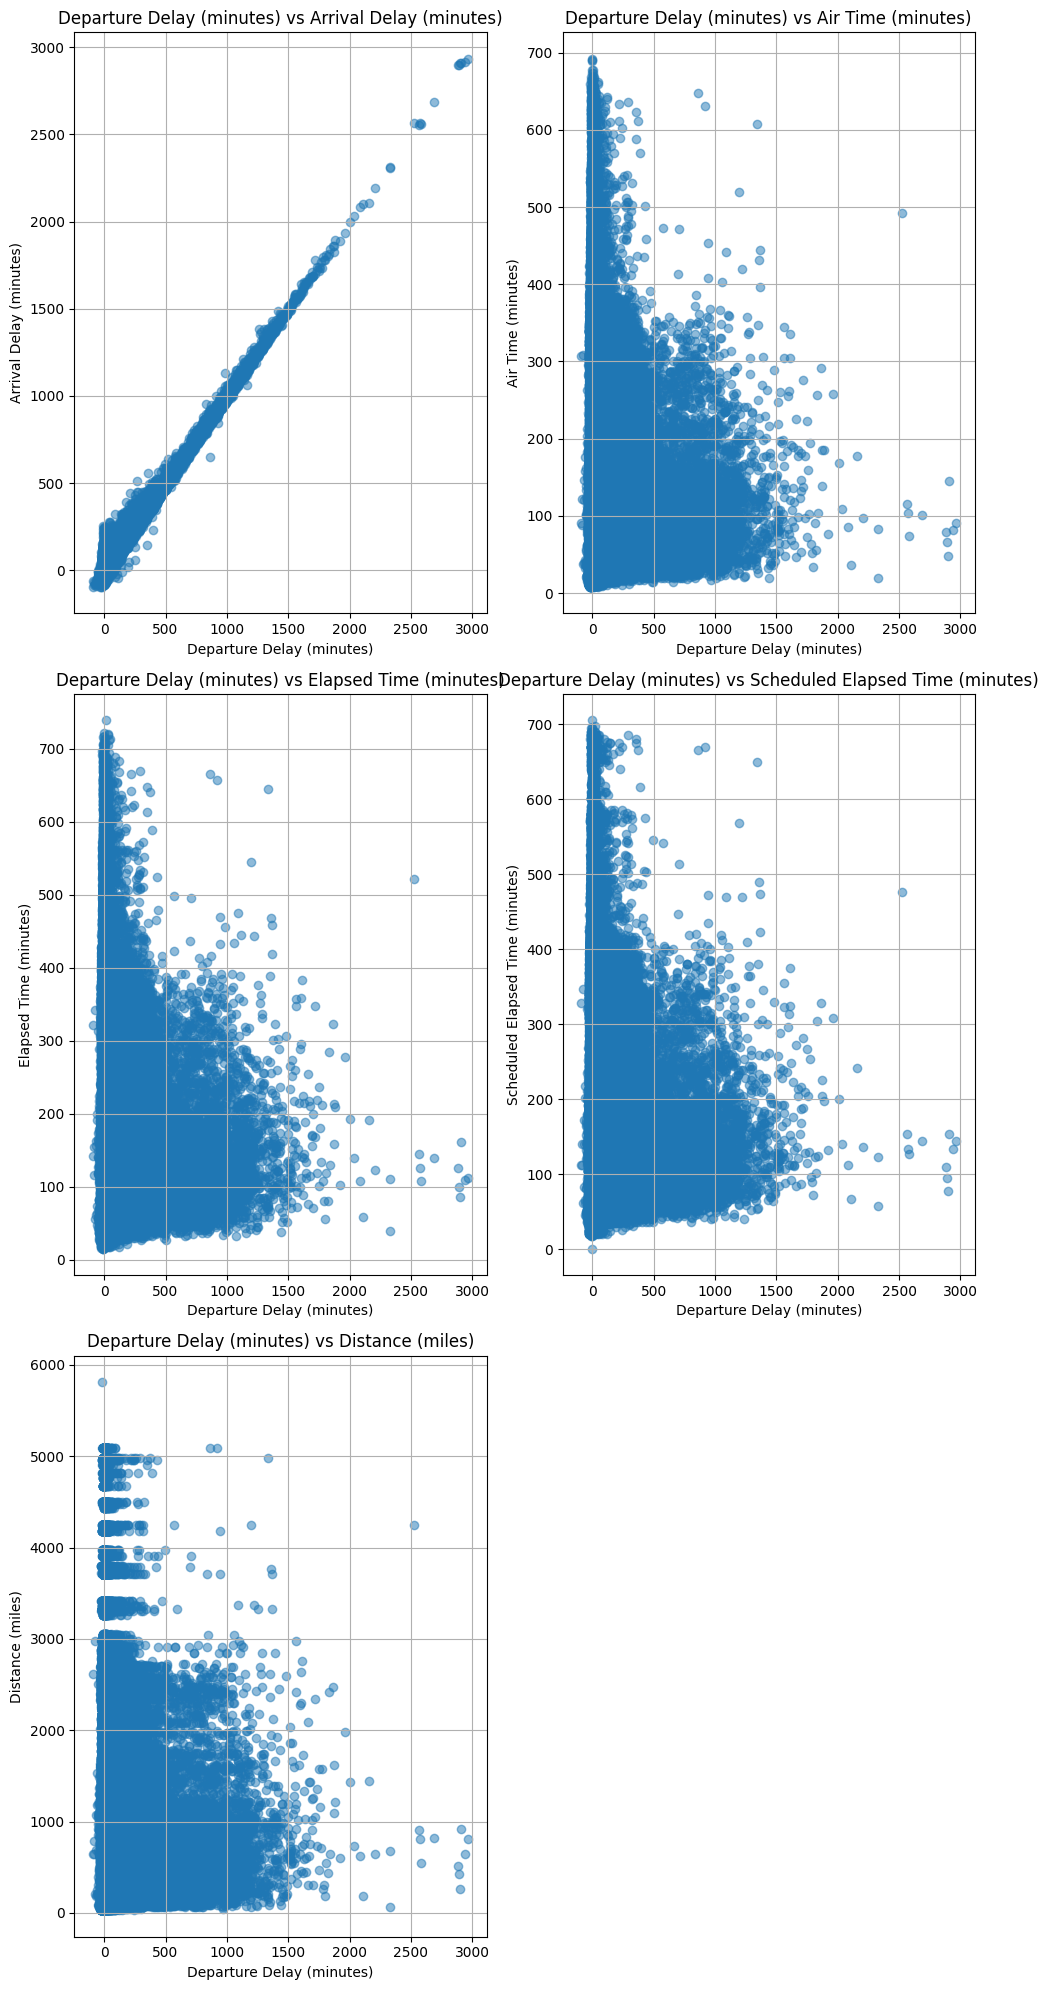

In [12]:
# Features' combination to consider while creating Scatterplots
scatter_combinations = [
    ('DEP_DELAY', 'ARR_DELAY', 'Departure Delay (minutes)', 'Arrival Delay (minutes)'),
    ('DEP_DELAY', 'AIR_TIME', 'Departure Delay (minutes)', 'Air Time (minutes)'),
    ('DEP_DELAY', 'ELAPSED_TIME', 'Departure Delay (minutes)', 'Elapsed Time (minutes)'),
    ('DEP_DELAY', 'CRS_ELAPSED_TIME', 'Departure Delay (minutes)', 'Scheduled Elapsed Time (minutes)'),
    ('DEP_DELAY', 'DISTANCE', 'Departure Delay (minutes)', 'Distance (miles)')
]

# Creation of scatterplots
plt.figure(figsize=(10, 20))
for i, (x_feature, y_feature, x_label, y_label) in enumerate(scatter_combinations, 1):
    plt.subplot(3, 2, i)
    plt.scatter(df[x_feature], df[y_feature], alpha=0.5)
    plt.title(f'{x_label} vs {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)

plt.tight_layout()
plt.show()

####Identified Observations
1. Departure Delay (DEP_DELAY) vs Arrival Delay (ARR_DELAY)

  This scatterplot shows a strong linear relationship between departure delays and arrival delays. As departure delays increase, arrival delays also increase correspondingly, indicating that flights with longer departure delays tend to experience proportionally similar arrival delays.

2. Departure Delay (DEP_DELAY) vs Air Time (AIR_TIME)

  There does not appear to be a strong or direct relationship between departure delays and air time. It is evident that longer departure delays do not directly affect air time, as flight durations remain relatively stable regardless of varying delays.
  
3. Scatterplot Analysis: Departure Delay (DEP_DELAY) vs Elapsed Time (ELAPSED_TIME)

  There is no strong correlation between departure delay and elapsed time. As departure delays increase, the spread of elapsed times remains quite large, but there is no clear linear relationship.

2. Departure Delay (DEP_DELAY) vs Distance (DISTANCE)

  There is no evident correlation between departure delay and flight distance. Flights with both short and long distances experience a broad range of departure delays, with no discernible trend indicating a direct relationship.

4. Departure Delay (DEP_DELAY) vs Scheduled Elapsed Time (CRS_ELAPSED_TIME)

  Scheduled elapsed time does not seem to significantly influence departure delays. The distribution of delays appears random across different scheduled durations, suggesting no consistent pattern.


####General Conclusions
- The strongest observed relationship is between DEP_DELAY and ARR_DELAY, where a clear linear pattern exists, reinforcing the idea that departure delays are a primary cause of arrival delays.
- No strong correlation is observed between departure delays and variables such as air time, flight distance, or scheduled elapsed time.
- The distribution of data points suggests that departure delays may be influenced by external factors rather than the flight’s intrinsic characteristics.



# DATA CLEANING REPORT
Data cleaning addresses issues such as missing values, errors, duplicates, and noise that could negatively impact the analysis. Three of the most common issues are noisy data, outliers or anomalies and missing values.

According to the output of Data Quality Verification:
- Useless columns containing the majority of null values will be deleted, along with useless columns with respect to the main goal defined for this project;
- Remaining rows containing NaN values will be dropped, considering that their amount represents only a small percentage of the entire dataset.
- Usage of a single type per departure and arrival of both types (CRS and not);
- Inconsistencies will be treated applying a conversion of “2400” (2400.0) values into “0000” (0000.0) ones.

In [13]:
# Deletion of useless columns almost entirely empty
# Deletion of useless column ARR_DELAY due to its correlation (it's common knowledge)
# Deletion of useless column DEP_TIME (it's common knowledge)
to_delete = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT",
    "CANCELLATION_CODE",
    "ARR_DELAY",
    "DEP_TIME"
]
df = df.drop(columns=to_delete, errors='ignore')

print("Available columns:", df.columns)

Available columns: Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE'],
      dtype='object')


In [14]:
# Columns containing rows with null values to be removed
contain_null_rows = [
    "DEP_DELAY",
    "TAXI_OUT",
    "WHEELS_OFF",
    "WHEELS_ON",
    "TAXI_IN",
    "ARR_TIME",
    "CRS_ELAPSED_TIME",
    "ELAPSED_TIME",
    "AIR_TIME"
]

df = df.dropna(subset=contain_null_rows)

# Looking for missing values after deletion
print("\nNumber of missing values per column after deletion:")
null_values_after_deletion = df.isnull().sum()
print(null_values_after_deletion)


Number of missing values per column after deletion:
FL_DATE             0
AIRLINE             0
AIRLINE_DOT         0
AIRLINE_CODE        0
DOT_CODE            0
FL_NUMBER           0
ORIGIN              0
ORIGIN_CITY         0
DEST                0
DEST_CITY           0
CRS_DEP_TIME        0
DEP_DELAY           0
TAXI_OUT            0
WHEELS_OFF          0
WHEELS_ON           0
TAXI_IN             0
CRS_ARR_TIME        0
ARR_TIME            0
CANCELLED           0
DIVERTED            0
CRS_ELAPSED_TIME    0
ELAPSED_TIME        0
AIR_TIME            0
DISTANCE            0
dtype: int64


In [15]:
# Usage of a single type per departure and arrival of both types (CRS and not)
print("Arrival Time in Minutes type (before): ", df['ARR_TIME'].dtype)
print("CRS Departure Time in Minutes type (before): ", df['CRS_DEP_TIME'].dtype)
print("CRS Arrival Time in Minutes type (before): ", df['CRS_ARR_TIME'].dtype)

df['ARR_TIME'] = df['ARR_TIME'].astype('int', )
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].astype('int', )
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype('int', )

print("Arrival Time in Minutes type (after): ", df['ARR_TIME'].dtype)
print("CRS Departure Time in Minutes type (before): ", df['CRS_DEP_TIME'].dtype)
print("CRS Arrival Time in Minutes type (before): ", df['CRS_ARR_TIME'].dtype)

Arrival Time in Minutes type (before):  float64
CRS Departure Time in Minutes type (before):  int64
CRS Arrival Time in Minutes type (before):  int64
Arrival Time in Minutes type (after):  int64
CRS Departure Time in Minutes type (before):  int64
CRS Arrival Time in Minutes type (before):  int64


In [16]:
# Conversion of '2400' values into '0000' in CRS_ARR_TIME,  ARR_TIME and DEP_TIME columns
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].replace(2400, 0)
df['ARR_TIME'] = df['ARR_TIME'].replace(2400, 0)

# Looking for values different from the hhmm format after conversion
crs_arr_time_valid = df['CRS_ARR_TIME'].apply(
    lambda x: isinstance(x, int) and 0 <= x < 2400 and 0 <= x % 100 < 60
)

arr_time_valid = df['ARR_TIME'].apply(
    lambda x: isinstance(x, int) and 0 <= x < 2400 and 0 <= x % 100 < 60
)

# Check consistency
if dep_time_valid.all() and arr_time_valid.all() and crs_arr_time_valid.all():
    print("All values in CRS_ARR_TIME, ARR_TIME and DEP_TIME columns are coherent with hhmm format.")
else:
    if not crs_arr_time_valid.all():
        print("\nNon valid values in CRS_ARR_TIME:")
        print(df.loc[~arr_time_valid, 'CRS_ARR_TIME'])
    if not arr_time_valid.all():
        print("\nNon valid values in ARR_TIME:")
        print(df.loc[~arr_time_valid, 'ARR_TIME'])

In [17]:
# Needed to apply the Label Encoder
df['FL_DATE'] = df['FL_DATE'].astype(str)

# Creation of a Dataframe copy
df_copy = df.copy()

# Conversion of nominal features into numerical ones
# (needed for Mutual Information that works with numbers)
label_encoders = {}
for column in df_copy.columns:
    if df_copy[column].dtype == 'object':
        le = LabelEncoder()
        df_copy[column] = le.fit_transform(df_copy[column])
        label_encoders[column] = le

print(df_copy.head())

   FL_DATE  AIRLINE  AIRLINE_DOT  AIRLINE_CODE  DOT_CODE  FL_NUMBER  ORIGIN  \
0        8       17           17            14     19977       1562     131   
1     1418        3            3             4     19790       1149     247   
2     1298       17           17            14     19977        459      99   
3     1525        3            3             4     19790       2295     247   
4      418       16           16            10     20416        407     223   

   ORIGIN_CITY  DEST  DEST_CITY  ...  WHEELS_ON  TAXI_IN  CRS_ARR_TIME  \
0          118   123        240  ...     1443.0      4.0          1501   
1          220   323        318  ...     2232.0     38.0          2315   
2           89   247        220  ...     1247.0      5.0          1252   
3          220   325        303  ...     1844.0      9.0          1829   
4          254   100         83  ...     2026.0     14.0          2041   

   ARR_TIME  CANCELLED  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  AIR_TIME  \
0 

# INCLUSION/EXCLUSION RATIONALE REPORT
In this project, since the goal is to perform a regression task and computational efficiency is a priority, the **Filter Model** was chosen for feature selection. Specifically, the **Mutual Information Measure** between each feature and the target one was used to compute the relevance of features, allowing for a fast and effective selection of the most informative subset.

Mutual Information allows to quantify the dependency between two given factors, that means quantifying how much information we gain with respect to a variable, knowing another one. Then, it allows us to sort the final results and choose the most relevant ones.

In [18]:
# Features and target one splitting
X = df_copy.drop('DEP_DELAY', axis=1)
y = df_copy['DEP_DELAY']

In [19]:
# Mutual Information computation
mutual_info = mutual_info_classif(X, y, discrete_features='auto')

# Dataframe creation
mutual_info_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mutual_info
})

# Features sorting with respect to their importance
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)

# Results' visualization
print(mutual_info_df)

             Feature  Mutual Information
1            AIRLINE            0.068318
2        AIRLINE_DOT            0.068144
3       AIRLINE_CODE            0.067988
4           DOT_CODE            0.067179
12        WHEELS_OFF            0.056935
13         WHEELS_ON            0.053732
16          ARR_TIME            0.053306
6             ORIGIN            0.044651
0            FL_DATE            0.043249
7        ORIGIN_CITY            0.042103
22          DISTANCE            0.038075
15      CRS_ARR_TIME            0.032204
8               DEST            0.029435
10      CRS_DEP_TIME            0.028686
9          DEST_CITY            0.025214
5          FL_NUMBER            0.023759
19  CRS_ELAPSED_TIME            0.016786
14           TAXI_IN            0.006031
21          AIR_TIME            0.005535
20      ELAPSED_TIME            0.005478
11          TAXI_OUT            0.004765
17         CANCELLED            0.000798
18          DIVERTED            0.000000


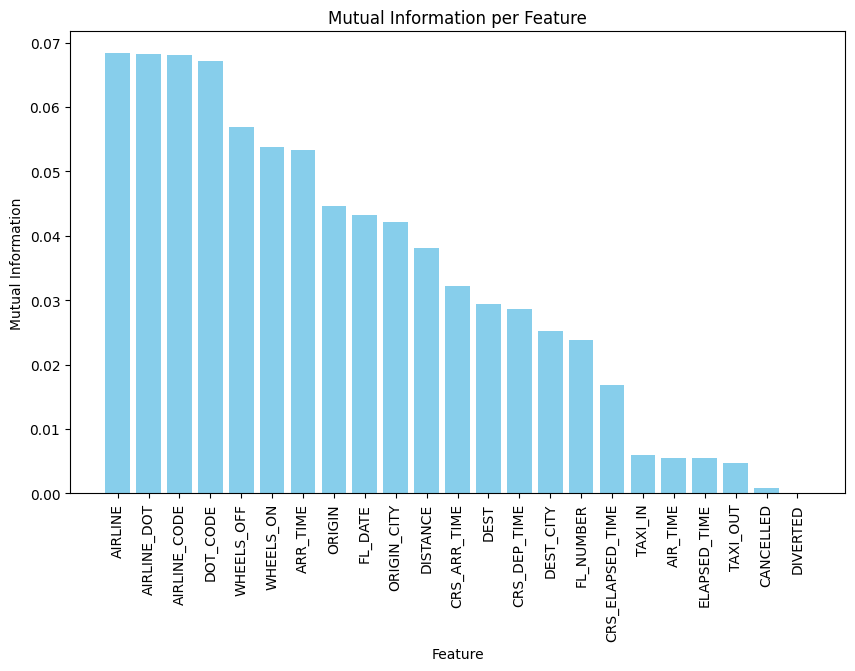

In [20]:
# Histogram plotting
plt.figure(figsize=(10, 6))
plt.bar(mutual_info_df['Feature'], mutual_info_df['Mutual Information'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.title('Mutual Information per Feature')
plt.xticks(rotation=90)
plt.show()

Features related to airline identification (AIRLINE, AIRLINE_CODE, AIRLINE_DOT, DOT_CODE) and operational metrics (WHEELS_OFF, WHEELS_ON, ARR_TIME) show the higher relevance with respect to the others, suggesting they should be retained in the modeling phase.

Features such as ORIGIN, FL_DATE, ORIGIN_CITY, DISTANCE, CSR_ARR_TIME, DEST, CSR_DEP_TIME, DEST_CITY, FL_NUMBER and CSR_ELAPSED_TIME exhibit moderate mutual information and may provide useful insights when combined with more influential variables.

On the other hand, several features demonstrate minimal mutual information with DEP_DELAY, indicating their limited predictive value. Consequently, the following features will be removed from the modeling process: AIR_TIME, ELAPSED_TIME, TAXI_IN, TAXI_OUT, DIVERTED, CANCELLED.

These variables either provide redundant or insignificant information regarding departure delays and, therefore, will not be included in further analysis.


In [21]:
# Non-dependent columns to delete
columns_to_drop = [
    'AIR_TIME', 'ELAPSED_TIME',
    'TAXI_IN', 'TAXI_OUT', 'DIVERTED', 'CANCELLED'
]

df_copy = df_copy.drop(columns=columns_to_drop)

print("Final dataset's first rows (encoded):")
print(df_copy.head())

Final dataset's first rows (encoded):
   FL_DATE  AIRLINE  AIRLINE_DOT  AIRLINE_CODE  DOT_CODE  FL_NUMBER  ORIGIN  \
0        8       17           17            14     19977       1562     131   
1     1418        3            3             4     19790       1149     247   
2     1298       17           17            14     19977        459      99   
3     1525        3            3             4     19790       2295     247   
4      418       16           16            10     20416        407     223   

   ORIGIN_CITY  DEST  DEST_CITY  CRS_DEP_TIME  DEP_DELAY  WHEELS_OFF  \
0          118   123        240          1155       -4.0      1210.0   
1          220   323        318          2120       -6.0      2123.0   
2           89   247        220           954        6.0      1020.0   
3          220   325        303          1609       -1.0      1635.0   
4          254   100         83          1840       -2.0      1853.0   

   WHEELS_ON  CRS_ARR_TIME  ARR_TIME  CRS_ELAPSED_TIME

In [22]:
# Non-dependent columns to delete
columns_to_drop = [
    'AIR_TIME', 'ELAPSED_TIME',
    'TAXI_IN', 'TAXI_OUT', 'DIVERTED', 'CANCELLED'
]

df = df.drop(columns=columns_to_drop)

print("Final dataset's first rows:")
print(df.head())

Final dataset's first rows:
      FL_DATE                AIRLINE                AIRLINE_DOT AIRLINE_CODE  \
0  2019-01-09  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
1  2022-11-19   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
2  2022-07-22  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
3  2023-03-06   Delta Air Lines Inc.   Delta Air Lines Inc.: DL           DL   
4  2020-02-23       Spirit Air Lines       Spirit Air Lines: NK           NK   

   DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST  \
0     19977       1562    FLL  Fort Lauderdale, FL  EWR   
1     19790       1149    MSP      Minneapolis, MN  SEA   
2     19977        459    DEN           Denver, CO  MSP   
3     19790       2295    MSP      Minneapolis, MN  SFO   
4     20416        407    MCO          Orlando, FL  DFW   

               DEST_CITY  CRS_DEP_TIME  DEP_DELAY  WHEELS_OFF  WHEELS_ON  \
0             Newark, NJ          1155       -4.0      1210.

In [23]:
# Final Dataset
df_copy.to_csv('final_dataset_encoded.csv', index=False)
df.to_csv('final_dataset.csv', index=False)